In [1]:
import os
import logging, os

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
from matplotlib import pyplot as plt
from musicnet.utils import Track, train_ids, notes_vocab, instruments_vocab
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from glob import glob
from musicnet.model.Transformer import AudioTransformer, TransformerLRSchedule
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.nn import weighted_cross_entropy_with_logits

2024-07-04 22:01:35.443138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 22:01:35.456898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 22:01:35.460779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
tf.__version__

'2.17.0-rc1'

In [5]:
tf.config.list_physical_devices("GPU")

I0000 00:00:1720123297.349450   17028 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720123297.374858   17028 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720123297.375048   17028 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
id = train_ids()[-1]
track = Track(id)
x_chunks, y_chunks = track.preprocess()

In [7]:
print(x_chunks.shape, y_chunks.shape)

(96, 998, 128) (96, 1000, 913)


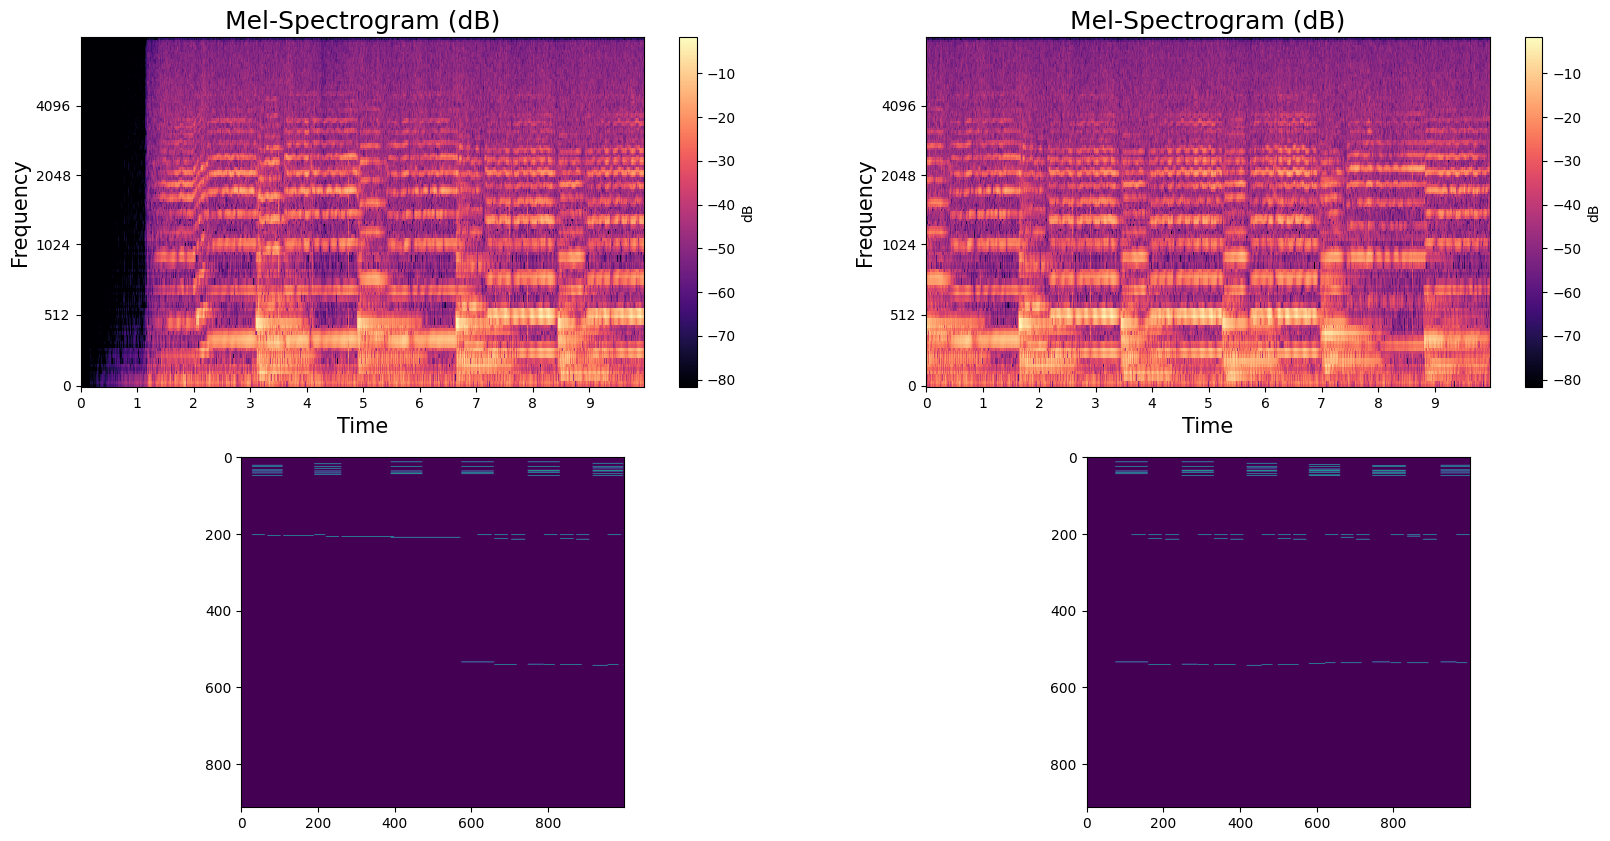

In [8]:
plt.figure(figsize=(20, 10))

for i in range(0, 2):
    plt.subplot(2, 2, i+1)
    librosa.display.specshow(
        x_chunks[i].T,
        sr=16000,
        x_axis="time",
        y_axis="mel",
        hop_length=160
    )
    plt.colorbar(label="dB")
    plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
    plt.xlabel('Time', fontdict=dict(size=15))
    plt.ylabel('Frequency', fontdict=dict(size=15))

for i in range(2, 4):
    plt.subplot(2, 2, i+1)
    plt.imshow(y_chunks[i].T)

In [9]:
n_mels=128
target_classes = len(notes_vocab) * len(instruments_vocab)

In [30]:
y_pred = np.array([
    [ # First sequence
        [0.7, 0, 0, 0],
        [0.7, 0, 0.7, 0.7],
        [0, 0, 0, 0],
        [0, 0.7, 0, 0]
    ],
    [ # Second sequence
        [0.7, 0.7, 0.7, 0.7],
        [0, 0, 0, 0],
        [0.7, 0.7, 0.7, 0.7],
        [0, 0, 0, 0]
    ]
])

y_true = np.array([
    [ # First sequence
        [1, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1]
    ],
    [ # Second sequence
        [0, 1, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1]
    ] 
])
f1 = keras.metrics.F1Score(threshold=0.5, average="macro")
f1.update_state(y_true.reshape(-1, 4), y_pred.reshape(-1, 4))

f1s = []
for c in range(0, 4):
    # Calculate precision, recall and f1 separately for each class:
    y_pred_c = y_pred[:, :, c].flatten()
    y_true_c = y_true[:, :, c].flatten()
    f1_c = f1_score(y_true_c, y_pred_c > 0.5)
    f1s.append(f1_c)
    print(c, {
        "precision":precision_score(y_true_c, y_pred_c > 0.5),
        "recall": recall_score(y_true_c, y_pred_c > 0.5),
        "f1": f1_c
    })

print("Final result: ", f1.result())
print("Avg f1:", np.mean(f1s))

0 {'precision': 0.5, 'recall': 0.5, 'f1': 0.5}
1 {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1': 0.6666666666666666}
2 {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
3 {'precision': 0.6666666666666666, 'recall': 0.4, 'f1': 0.5}
Final result:  tf.Tensor(0.6666666, shape=(), dtype=float32)
Avg f1: 0.6666666666666666


In [39]:
def plot_y_vs_y_pred(y, y_pred):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title("y_true")
    plt.imshow(y.T)
    plt.subplot(1, 2, 2)
    plt.title("y_pred")
    plt.imshow(y_pred.T)

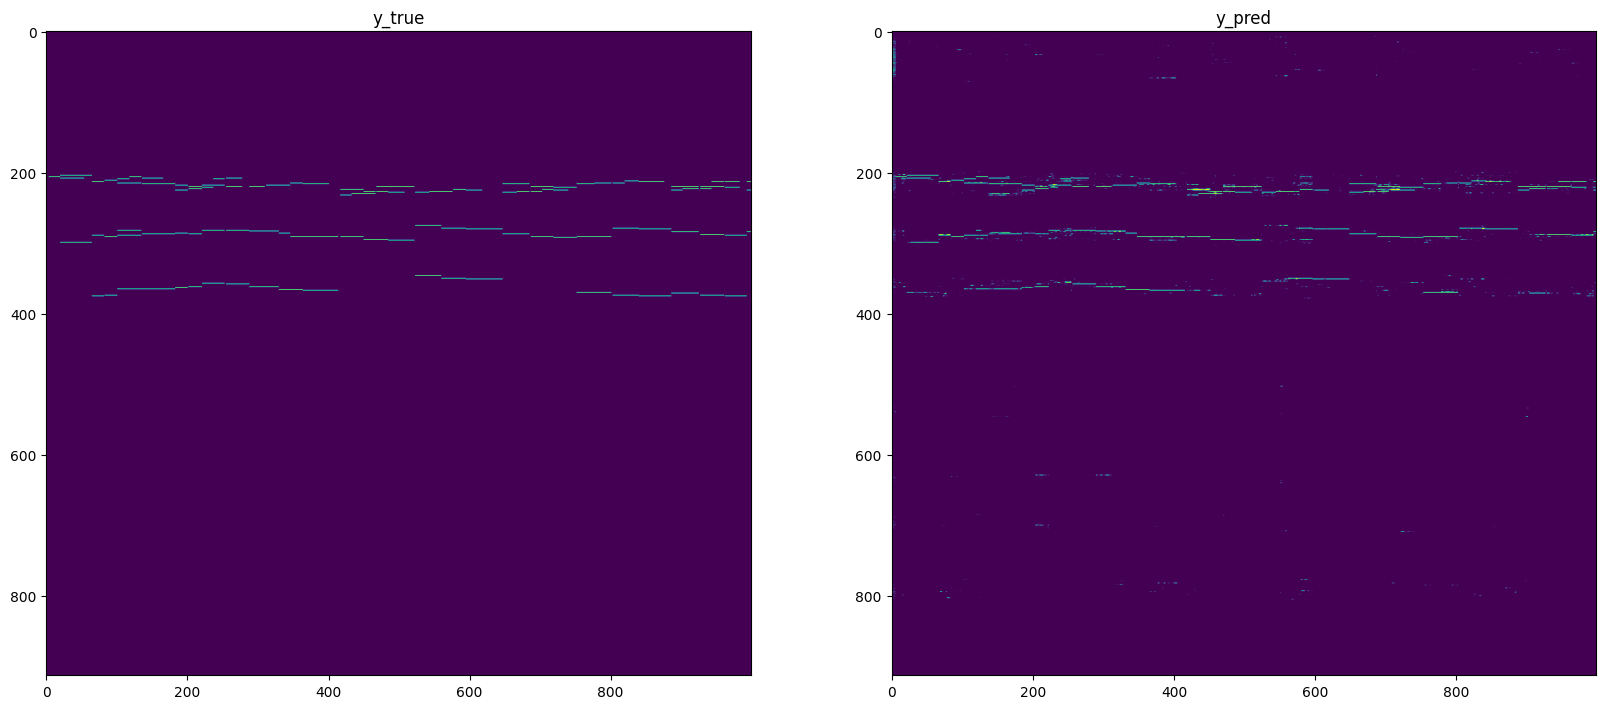

In [40]:
plot_y_vs_y_pred(y.numpy(), tf.sigmoid(y_pred).numpy())